In [41]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [42]:
# Constants for the API request
API_BASE_URL = "https://api.census.gov/data/2020/acs/acs5"
API_KEY = "ab5951c29c17af86ce00bcc921d36eaa7f678475"  # Replace with the actual API key
STATE_FIPS = "17"  # Illinois State FIPS code

# County FIPS codes within Illinois for the CMAP region
COUNTY_FIPS_CODES = [
    '031',  # Cook
    '043',  # DuPage
    '089',  # Kane
    '093',  # Kendall
    '097',  # Lake
    '111',  # McHenry
    '197'   # Will
]

In [43]:
# Age group variable codes in ACS B01001 table (This needs to be updated with actual codes)
AGE_GROUP_VARIABLES = {
    '0-4': ['B01001_003E', 'B01001_027E'],
    '5-19': ['B01001_004E', 'B01001_005E','B01001_006E', 'B01001_007E','B01001_028E', 'B01001_029E','B01001_030E', 'B01001_031E'],
    '20-34': ['B01001_008E', 'B01001_009E','B01001_010E', 'B01001_011E','B01001_012E', 'B01001_032E','B01001_033E', 'B01001_034E','B01001_035E', 'B01001_036E'],
    '35-49': ['B01001_013E', 'B01001_014E','B01001_015E', 'B01001_037E','B01001_038E', 'B01001_039E'],
    '50-64': ['B01001_016E', 'B01001_017E','B01001_018E', 'B01001_019E','B01001_040E', 'B01001_041E','B01001_042E', 'B01001_043E'],
    '65-74': ['B01001_020E', 'B01001_021E','B01001_022E', 'B01001_044E','B01001_045E', 'B01001_046E'],
    '75-84': ['B01001_023E', 'B01001_024E','B01001_047E', 'B01001_048E'],
    '+84': ['B01001_025E', 'B01001_049E'],
    }

In [44]:
# Function to fetch data for a single county
def fetch_data_for_county(county_fips_code):
    # Construct the query parameters for the request
    variables = "NAME," + ",".join([f"B01001_{i:03d}E" for i in range(1, 50)])  # Update with actual variables needed
    url = f"{API_BASE_URL}?get={variables}&for=county:{county_fips_code}&in=state:{STATE_FIPS}&key={API_KEY}"
    response = requests.get(url)
    return response.json()

# Function to fetch data for all CMAP counties
def fetch_all_data():
    all_data = []
    for county_fips in COUNTY_FIPS_CODES:
        county_data = fetch_data_for_county(county_fips)
        # Skip the header row for all but the first county
        if all_data:
            county_data = county_data[1:]
        all_data.extend(county_data)
    return all_data

In [45]:
# Function to convert JSON to DataFrame
def json_to_dataframe(json_data):
    header = json_data[0]
    data = json_data[1:]
    df = pd.DataFrame(data, columns=header)
    return df

In [46]:
# Function to aggregate data into the specified age ranges
def aggregate_data(df):
    # Initialize a dictionary to hold the aggregated data
    aggregated_data = {}
    for age_group, variables in AGE_GROUP_VARIABLES.items():
        # Sum the male and female counts for each age group
        df[age_group] = df[variables].astype(int).sum(axis=1)
        # Sum across all counties to get the total for each age group
        aggregated_data[age_group] = df[age_group].sum()
    return aggregated_data

In [47]:
# Function to export data to CSV
def export_to_csv(aggregated_data):
    total_population = sum(aggregated_data.values())
    data_for_csv = {
        'Age Range': list(aggregated_data.keys()),
        'Population': list(aggregated_data.values()),
        'Percent of Total Population': [(count / total_population) * 100 for count in aggregated_data.values()]
    }
    df_for_csv = pd.DataFrame(data_for_csv)
    df_for_csv.to_csv('cmap_population_by_age_group.csv', index=False)

In [48]:
# Function to display the aggregated data as a table in the Jupyter Notebook
def display_aggregated_data(aggregated_data):
    total_population = sum(aggregated_data.values())
    data_for_display = {
        'Age Range': list(aggregated_data.keys()),
        'Population': list(aggregated_data.values()),
        'Percent of Total Population': [f"{(count / total_population) * 100:.2f}%" for count in aggregated_data.values()]
    }
    df_for_display = pd.DataFrame(data_for_display)
    display(df_for_display)

In [49]:
# Function to create a pyramid chart
def create_pyramid_chart(aggregated_data):
    age_groups = list(aggregated_data.keys())
    population_percentages = [(count / sum(aggregated_data.values())) * 100 for count in aggregated_data.values()]
    plt.barh(age_groups, population_percentages)
    plt.xlabel('Percent of Total Population')
    plt.title('Population Pyramid for CMAP Region')
    plt.savefig('population_pyramid.png')

,Age Range,Population,Percent of Total Population
0,0-4,508895,6.02%
1,5-19,1624354,19.22%
2,20-34,1781246,21.08%
3,35-49,1688609,19.98%
4,50-64,1625883,19.24%
5,65-74,713897,8.45%
6,75-84,348205,4.12%
7,+84,160449,1.90%


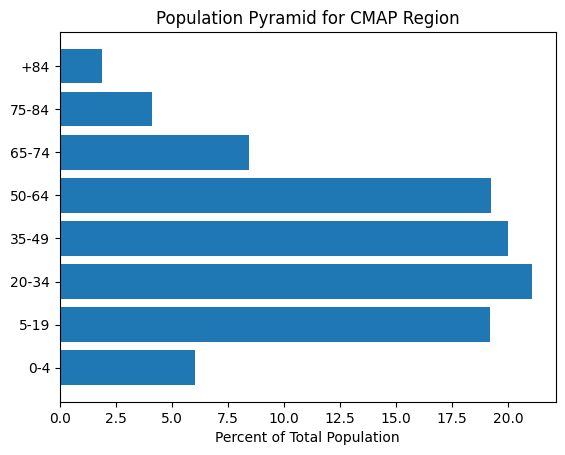

In [40]:
# Main execution
if __name__ == "__main__":
    json_data = fetch_all_data()
    df = json_to_dataframe(json_data)
    aggregated_data = aggregate_data(df)
    
    # Display the aggregated data as a table in the Jupyter Notebook
    display_aggregated_data(aggregated_data)
    export_to_csv(aggregated_data)
    create_pyramid_chart(aggregated_data)

<table>
  <tr>
    <td style="border-right:1px solid black;"><strong>Data Source</strong></td>
    <td>The graph is based on data from the American Community Survey (ACS) for the years 2016-2020, specifically the detailed table B01001 which provides sex by age data.</td>
  </tr>
  <tr>
    <td style="border-right:1px solid black;"><strong>Highest Age Group</strong></td>
    <td>The age group '20-34' (Millennials) has the highest percentage of the population, accounting for approximately 21.08% of the total population in the CMAP region.</td>
  </tr>
  <tr>
    <td style="border-right:1px solid black;"><strong>Geographical Scope</strong></td>
    <td>The data is for the CMAP region, which includes the seven Illinois counties of Cook, DuPage, Kane, Kendall, Lake, McHenry, and Will.</td>
  </tr>
  <tr>
    <td style="border-right:1px solid black;"><strong>Time Frame</strong></td>
    <td>The data reflects a 5-year estimate, which means it is not for a specific year but rather collected over a period of 5 years (2016-2020). This approach provides a larger sample size, which can be useful for analyzing populations in smaller areas (like counties) where annual sample sizes might be too small for accurate estimates.</td>
  </tr>
  <tr>
    <td colspan="2" style="border-bottom:1px solid black;"><strong>More Details</strong></td>
  </tr>
  <tr>
    <td style="border-right:1px solid black;">The age group '0-4' years (Gen Z and later)</td>
    <td>makes up 6.02% of the population, indicating the proportion of very young residents in the region.</td>
  </tr>
  <tr>
    <td style="border-right:1px solid black;">The '5-19' years (Gen Z and later) and '35-49' years (Gen X) age groups</td>
    <td>are relatively similar in size, each making up just under 20% of the population. This could indicate stability in the population's age distribution over time.</td>
  </tr>
  <tr>
    <td style="border-right:1px solid black;">The '50-64' years age group (Boomers)</td>
    <td>also holds a significant portion of the population, at 19.24%, which suggests that the population is aging, as this group will move into the older age categories over time.</td>
  </tr>
  <tr>
    <td style="border-right:1px solid black;">The '65-74' years age group</td>
    <td>represents 8.45% of the population, showing a smaller but still significant segment of elderly residents.</td>
  </tr>
  <tr>
    <td style="border-right:1px solid black;">The '75-84' years and '85+' years age groups</td>
    <td>are the smallest, at 4.12% and 1.90% respectively, which is common as the population naturally decreases with age.</td>
  </tr>
</table>